<h1 style="text-align: center;">Modelagem - CASH-OUT

## Configs

In [2]:
## bibliotecas
import time
tic = time.time()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import *
from scipy.stats import * 

from utils.eda import *
from utils.modelling_tools import *

%load_ext autoreload
%autoreload 2

In [3]:
## configurações

np.set_printoptions()
np.set_printoptions(precision=4, suppress=True)

pd.options.display.float_format = '{:.4f}'.format

%matplotlib inline
# from matplotlib import rcParams

# plt_params = {
#     'figure.figsize':(6,4),
#     'figure.dpi':75,
#     'font.size':16,
#     'font.family':'serif',
#     'xtick.labelsize':14,
#     'ytick.labelsize':14,
#     'axes.labelsize':14,
#     'legend.fontsize':10,
#     'lines.linewidth':12,
#     'grid.color':'gray',
#     'savefig.bbox':'tight',
#     'savefig.dpi':1000,
#     'savefig.transparent':False,
# }

# rcParams.update(plt_params)

import warnings
warnings.filterwarnings('ignore')

seed = 123

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [4]:
## Carregando dataset
file_path = f'dados/df_cashout_treino_sample_transformada.parquet'
# file_path = f'dados/df_cashout_treino_sample.parquet'

df = pd.read_parquet(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10110748 entries, 0 to 10110747
Data columns (total 38 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   transaction_amount_total             float64       
 1   test_transaction                     float64       
 2   sum_amount_same_doc_in_1H            float64       
 3   sum_amount_same_doc_in_7D            float64       
 4   sum_amount_same_doc_in_30D           float64       
 5   count_amount_same_doc_in_1H          float64       
 6   count_amount_same_doc_in_7D          float64       
 7   count_amount_same_doc_in_30D         float64       
 8   mean_amount_same_doc_in_1H           float64       
 9   mean_amount_same_doc_in_7D           float64       
 10  mean_amount_same_doc_in_30D          float64       
 11  std_amount_in_1H                     float64       
 12  std_amount_in_7D                     float64       
 13  std_amount_in_30D        

### Criando Variável Resposta

In [5]:
df['last_status'].value_counts()

last_status
APPROVED           10092900
REJECTED              17541
SUSPECTED_FRAUD         255
FRAUD                    49
CONT_FRAUD                3
Name: count, dtype: Int64

In [6]:
## Definição da variável-resposta
## Cria a coluna target  

## Target FRAUD, SUSPECTED_FRAUD e REJECTED
# df['target'] = np.where(df['last_status'].isin(['FRAUD', 'SUSPECTED_FRAUD', 'CONT_FRAUD', 'REJECTED']), 1, 0)

## Target FRAUD e SUSPECTED_FRAUD
# testar como feature do modelo 
df['rejected'] = np.where(df['last_status'].isin(['REJECTED']), 1, 0)
# df = df[df['last_status'] != 'REJECTED'] ## remove os rejeitados para não ter ruído, DA PRA MANTER PQ A TRANSFEERA ESTA EM GHOST MODE

# df['target'] = np.where(df['last_status'].isin(['FRAUD', 'CONT_FRAUD']), 1, 0)
df['target'] = np.where(df['last_status'].isin(['FRAUD', 'CONT_FRAUD']), 1, 0)

df['target'].value_counts()

target
0    10110696
1          52
Name: count, dtype: int64

In [7]:
pd.concat([df['target'].value_counts().rename('counts'),
            df['target'].value_counts(normalize=True).rename('frequency')], axis=1)

,counts,frequency
target,,
0,10110696,1.0000
1,52,0.0000


In [8]:
target =  df['last_status']
transaction_id =  df['transaction_id']

### Definindo Variáveis Numéricas

In [9]:
df['transaction_datetime_request'].describe(percentiles=[.7, .75, .8, .9])

count                         10110748
mean     2024-08-25 09:59:06.496976128
min                2024-05-01 03:00:28
50%      2024-08-26 19:02:48.489999872
70%      2024-09-28 14:54:47.628499968
75%      2024-10-02 03:07:51.880999936
80%      2024-10-07 14:32:40.790000128
90%      2024-10-22 18:33:44.240300032
max         2024-11-06 22:53:21.075000
Name: transaction_datetime_request, dtype: object

In [10]:
df = df.sort_values('transaction_datetime_request')

data_split = '2024-07-15'

df_train = df[df['transaction_datetime_request'] < data_split]
df_test = df[df['transaction_datetime_request'] >= data_split]

## Separando bases de Treino e Teste
y_train = df_train['target']
X_train_full = df_train.drop('target', axis=1)
transaction_id_X_train = X_train_full['transaction_id']
transaction_datetime_request_X_train = X_train_full['transaction_datetime_request']
fraud_X_train = X_train_full['fraud']
last_status_X_train = X_train_full['last_status']

y_test = df_test['target']
X_test_full = df_test.drop('target', axis=1)
transaction_id_X_test = X_test_full['transaction_id']
transaction_datetime_request_X_test = X_test_full['transaction_datetime_request']
fraud_X_test = X_test_full['fraud']
last_status_X_test = X_test_full['last_status']

# X_test_full.drop('transaction_id', axis='columns', inplace=True)
X_train_full.drop(['fraud', 'hora', 'dia', 'dia_semana', 'test_transaction'], axis='columns', inplace=True)

y_train.sum(), y_test.sum()

(23, 29)

In [11]:
# train_size = int(0.8 * len(X))  # Use 80% for training, 20% for testing
# X_train_full, X_test_full = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# transaction_id_X_test = X_test_full['transaction_id']
# fraud_X_test = X_test_full['fraud']

# X_test_full.drop('transaction_id', axis='columns', inplace=True)
# X_train_full.drop(['transaction_id','fraud', 'hora', 'dia', 'dia_semana', 'test_transaction'], axis='columns', inplace=True)

# y_train.sum(), y_test.sum()


In [12]:
X_train_full['transaction_datetime_request'].describe()

count                          2200098
mean     2024-06-25 18:06:21.015930368
min                2024-05-01 03:00:28
25%      2024-06-17 16:36:30.203000064
50%      2024-06-25 18:51:22.112999936
75%      2024-07-04 18:02:27.471000064
max         2024-07-14 23:59:59.152000
Name: transaction_datetime_request, dtype: object

In [13]:
X_test_full['transaction_datetime_request'].describe()

count                          7910650
mean     2024-09-11 06:53:31.504593152
min         2024-07-15 00:00:00.692000
25%      2024-08-13 18:36:38.620999936
50%                2024-09-11 21:12:19
75%      2024-10-07 19:12:42.052999936
max         2024-11-06 22:53:21.075000
Name: transaction_datetime_request, dtype: object

In [14]:
numerics = ['int16','int32','int64','float16','float32','float64']
numeric_features = X_train_full.select_dtypes(include=numerics).columns
X_train = X_train_full[numeric_features]
X_test = X_test_full[numeric_features]

In [15]:
#### IV 
iv, woe = iv_woe(data=pd.concat([X_train, y_train]),
                target='target',
                bins=25, show_woe=False)

iv['Predictive Power'] = iv['IV'].map(predictive_power)
iv.shape

Information value of transaction_amount_total is 6.23282
Information value of sum_amount_same_doc_in_1H is 6.23282
Information value of sum_amount_same_doc_in_7D is 6.23282
Information value of sum_amount_same_doc_in_30D is 6.23282
Information value of count_amount_same_doc_in_1H is 3.739692
Information value of count_amount_same_doc_in_7D is 4.48763
Information value of count_amount_same_doc_in_30D is 4.986256
Information value of mean_amount_same_doc_in_1H is 6.23282
Information value of mean_amount_same_doc_in_7D is 6.23282
Information value of mean_amount_same_doc_in_30D is 6.23282
Information value of std_amount_in_1H is 3.739692
Information value of std_amount_in_7D is 4.736943
Information value of std_amount_in_30D is 5.235568
Information value of amount_7D_1H is 4.238317
Information value of amount_30d_7d is 3.739692
Information value of behav_increase_7d_1H_amount is 4.238317
Information value of behav_increase_30d_7d_amount is 3.739692
Information value of transacoes_unicas_p

(31, 3)

In [16]:
#  testar sem feature selection e testar o corte mais alto (.95) 
def select_features_by_correlation(df, threshold=0.9):
    # Passo 1: Computa a matriz de correlação
    corr_matrix = df.corr().abs()
    
    # Passo 2: Cria uma máscara para identificar pares de variáveis altamente correlacionadas (correlação > threshold)
    mask = (corr_matrix > threshold) & (corr_matrix < 1)
    
    # Passo 3: Identifica quais variáveis devem ser removidas
    features_to_drop = set()
    for row in range(len(corr_matrix.columns)):
        for col in range(row):
            if mask.iloc[row, col]:
                # Compara a correlação de cada variável no par com as outras variáveis
                feature_1 = corr_matrix.columns[row]
                feature_2 = corr_matrix.columns[col]

                # Obtém a correlação de cada variável com todas as outras variáveis
                corr_with_feature_1 = corr_matrix[feature_1].drop([feature_1, feature_2])
                corr_with_feature_2 = corr_matrix[feature_2].drop([feature_1, feature_2])

                # Calcula a soma absoluta da correlação de cada variável com as outras
                corr_to_other_variables_1 = np.abs(corr_with_feature_1.sum())
                corr_to_other_variables_2 = np.abs(corr_with_feature_2.sum())

                # Mantém a variável com a menor correlação média com as outras
                if corr_to_other_variables_1 < corr_to_other_variables_2:
                    features_to_drop.add(feature_2)
                else:
                    features_to_drop.add(feature_1)

    # Passo 4: Remove as variáveis selecionadas
    df_reduced = df.drop(columns=features_to_drop)

    return df_reduced, features_to_drop, corr_matrix

X_train, to_drop, corr_matrix = select_features_by_correlation(X_train[numeric_features])

if 'transaction_amount_total' in to_drop:
    to_drop.remove('transaction_amount_total')

to_drop

{'amount_7D_1H',
 'count_amount_same_doc_in_30D',
 'count_amount_same_doc_in_7D',
 'desvio_relativo_media_in_1H',
 'desvio_relativo_media_in_7D',
 'mean_amount_same_doc_in_1H',
 'mean_amount_same_doc_in_7D',
 'razao_valor_frequencia_30D',
 'sum_amount_same_doc_in_30D',
 'sum_amount_same_doc_in_7D',
 'transacoes_unicas_pagador_recebedor'}

In [17]:
pd.concat([y_train.value_counts().rename('counts'),
            y_train.value_counts(normalize=True).rename('frequency')], axis=1)

,counts,frequency
target,,
0,2200075,1.0000
1,23,0.0000


In [18]:
pd.concat([y_test.value_counts().rename('counts'),
            y_test.value_counts(normalize=True).rename('frequency')], axis=1)

,counts,frequency
target,,
0,7910621,1.0000
1,29,0.0000


## Random Forest Model

In [19]:
ratio_of_bads = df.shape[0]/df['fraud'].sum()
ratio_of_bads =  81_500 # ratio mês de JULHO

ratio_of_bads

81500

In [20]:
X_train

,transaction_amount_total,sum_amount_same_doc_in_1H,count_amount_same_doc_in_1H,mean_amount_same_doc_in_30D,std_amount_in_1H,std_amount_in_7D,std_amount_in_30D,amount_30d_7d,behav_increase_7d_1H_amount,behav_increase_30d_7d_amount,recebedores_unicos_por_pagador,pagadores_unicos_por_recebedor,razao_valor_frequencia_1H,razao_valor_frequencia_7D,roc_razao_valor_frequencia_1H,roc_razao_valor_frequencia_7D,roc_razao_valor_frequencia_30D,flag_first_time_receiver,desvio_relativo_media_in_30D,rejected
0,0.9127,0.9127,0.0010,1.2563,-6.9078,-6.9078,-6.9078,-6.9078,-6.9078,0.0316,1.0002,0.0010,1.2563,1.2563,0.1778,-6.9078,-6.9078,1.0005,1.0002,0
1,4.7902,4.7902,0.0010,3.3120,-6.9078,-6.9078,-6.9078,-6.9078,-6.9078,0.0316,1.1894,0.0010,2.7994,2.7994,2.2056,3.1639,3.1639,1.0005,1.0002,0
2,3.7975,3.7975,0.0010,2.5841,-6.9078,-6.9078,-6.9078,-6.9078,-6.9078,0.0316,1.3162,0.0010,2.7332,2.7332,NaN,NaN,NaN,1.0005,1.0002,0
3,4.6052,4.6052,0.0010,3.1623,-6.9078,-6.9078,-6.9078,-6.9078,-6.9078,0.0316,1.4143,0.0010,2.8594,2.8594,0.6679,-1.6144,-1.6144,1.0005,1.0002,0
4,2.8798,2.8798,0.0010,2.0543,-6.9078,-6.9078,-6.9078,-6.9078,-6.9078,0.0316,1.4954,0.0010,2.7482,2.7482,NaN,NaN,NaN,1.0005,1.0002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200093,5.5215,11.9096,6.1312,4.4564,6.9761,6.9132,6.9595,12.9159,4.7943,0.9380,3.6930,6.2879,4.2401,4.4353,0.1500,-6.9084,-6.9085,0.0316,0.8926,0
2200094,5.0106,10.7773,5.8579,3.4101,6.6134,6.4006,6.3368,11.5703,4.3821,0.8887,5.7824,6.2879,3.4043,3.4430,0.1908,-6.8859,-6.9069,0.0316,1.0265,0
2200095,0.9862,5.2539,4.1744,1.6836,-0.1074,1.8137,2.5568,9.0344,4.6624,0.7402,1.4954,0.0010,3.2795,2.2044,0.1778,-7.0372,-6.9654,0.0316,0.7606,0
2200096,2.3027,10.7775,5.8608,3.4101,6.6120,6.4006,6.3368,11.5703,4.3792,0.8887,5.7824,6.2879,3.4021,3.4430,NaN,-6.9302,-6.9162,0.0316,0.5232,0


In [21]:
modelo = 'BalancedRandomForestClassifier'
feature_names = X_train.columns

from imblearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier

model = BalancedRandomForestClassifier(random_state=seed)
pipeline = Pipeline([
    ('model', model)
])


param_grid = {
    'model__min_samples_leaf': [5],
    'model__max_depth': [5],
    'model__min_samples_split': [5],
    'model__max_features': [int(X_train.shape[1]/3)],
    'model__class_weight': [{0:1, 1:ratio_of_bads}]
                }

param_grid = {}

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1',
    refit='f1',
    cv=2,
    n_jobs=-1,
    return_train_score=True,
    verbose=2
)

In [22]:
# grid_search.fit(X_train, y_train)
# best_model = grid_search.best_estimator_

## salva modelo em pickle
# with open('model_new_features_30_dias_descorrelacionadas.pkl', 'wb') as model_file:
#     pickle.dump(best_model, model_file)

steps=[('model',  
BalancedRandomForestClassifier(bootstrap=False,  
class_weight={0: 1, 1: 163000},  
max_depth=10,  
min_samples_leaf=2,  
n_estimators=250,  
random_state=123))]

In [23]:
## carregando o modelo 
with open('model_new_features_30_dias_descorrelacionadas.pkl', 'rb') as model_file:
    best_model = pickle.load(model_file)

In [24]:
best_model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('model', BalancedRandomForestClassifier(random_state=123))])>

In [25]:
importances = best_model.named_steps['model'].feature_importances_

len(feature_names), len(importances)

(20, 20)

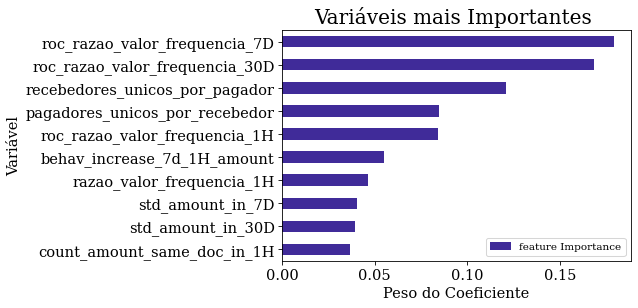

In [26]:
## Coleta o nome das features 
random_forest_feature_importance = pd.DataFrame(feature_names, columns=['Variável']) 
## calcula o peso de w_n quando x_n <= x_n+1
random_forest_feature_importance['feature Importance'] = importances
random_forest_feature_importance = random_forest_feature_importance.sort_values(by=['feature Importance'], ascending=False)
## Reset no valor do index para rankear
random_forest_feature_importance.reset_index(inplace=True, drop=True)
## Construindo Ranking e adicionando para não iniciar por zero
random_forest_feature_importance['feature Rank'] = random_forest_feature_importance.index+1

ax = random_forest_feature_importance.iloc[0:10].plot.barh(x='Variável', y='feature Importance', color='#402b99')
ax.invert_yaxis()
plt.title('Variáveis mais Importantes ')
plt.xlabel('Peso do Coeficiente')
plt.show();

In [27]:
random_forest_feature_importance['Variável']

0      roc_razao_valor_frequencia_7D
1     roc_razao_valor_frequencia_30D
2     recebedores_unicos_por_pagador
3     pagadores_unicos_por_recebedor
4      roc_razao_valor_frequencia_1H
5        behav_increase_7d_1H_amount
6          razao_valor_frequencia_1H
7                   std_amount_in_7D
8                  std_amount_in_30D
9        count_amount_same_doc_in_1H
10          transaction_amount_total
11         razao_valor_frequencia_7D
12      desvio_relativo_media_in_30D
13      behav_increase_30d_7d_amount
14       mean_amount_same_doc_in_30D
15         sum_amount_same_doc_in_1H
16                     amount_30d_7d
17                  std_amount_in_1H
18          flag_first_time_receiver
19                          rejected
Name: Variável, dtype: object

In [28]:
## Associando Feature Importance com IV
df_random_forest_feature_importance = pd.merge(random_forest_feature_importance, iv, how='inner',
                                    left_on='Variável', right_on='Variable').drop('Variable', axis=1)


df_random_forest_feature_importance

,Variável,feature Importance,feature Rank,IV,Predictive Power
0,roc_razao_valor_frequencia_7D,0.1793,1,4.2383,suspicious
1,roc_razao_valor_frequencia_30D,0.1687,2,4.2383,suspicious
2,recebedores_unicos_por_pagador,0.1210,3,5.9835,suspicious
3,pagadores_unicos_por_recebedor,0.0847,4,3.4904,suspicious
4,roc_razao_valor_frequencia_1H,0.0840,5,3.4904,suspicious
5,behav_increase_7d_1H_amount,0.0549,6,4.2383,suspicious
6,razao_valor_frequencia_1H,0.0466,7,6.2328,suspicious
7,std_amount_in_7D,0.0403,8,4.7369,suspicious
8,std_amount_in_30D,0.0393,9,5.2356,suspicious
9,count_amount_same_doc_in_1H,0.0368,10,3.7397,suspicious


#### Avaliação Modelo

In [29]:
y_pred_train, yprob_train, random_forest_rocauc_train, random_forest_aucpr_train = model_eval(best_model, X_train[X_train.columns], y_train)

Accuracia: 96.84%
AUC-ROC Score médio: 0.9998
AUC-PR Score médio: 0.4396


In [30]:
y_pred, yprob, random_forest_rocauc, random_forest_aucpr = model_eval(best_model, X_test[X_train.columns], y_test)

df_clf = pd.DataFrame({'target': y_test, 'yprob':yprob[:,1]})
print(f'Balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.2%}')
print(f'Jaccard: {jaccard_score(y_test, y_pred):.2%}')

Accuracia: 98.50%
AUC-ROC Score médio: 0.9357
AUC-PR Score médio: 0.0003
Balanced accuracy: 66.49%
Jaccard: 0.01%


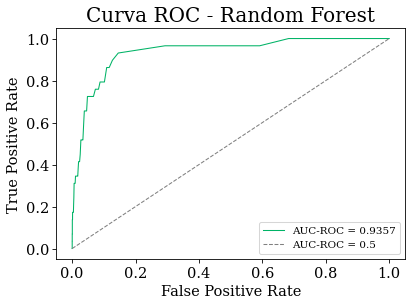

In [31]:
random_forest_fpr, random_forest_tpr, random_forest_thresholds = roc_curve(y_test, yprob[:,1])
figura = plot_curva_roc(random_forest_fpr, random_forest_tpr, random_forest_rocauc, 'Random Forest')

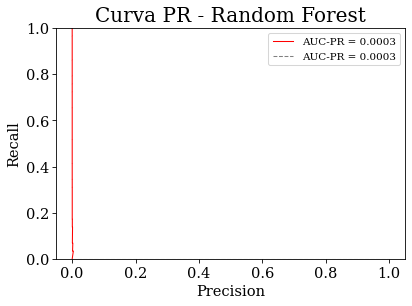

In [32]:
random_forest_precision, random_forest_recall, random_forest_thresholds_pr = precision_recall_curve(y_test, yprob[:,1])
figura = plot_curva_pr(random_forest_precision, random_forest_recall, random_forest_aucpr, 'Random Forest')

In [33]:
df_clf = pd.DataFrame({'target': y_test, 'yprob':yprob[:,1]})

random_forest_stat_ks, random_forest_ks_val = ks(df_clf)

KS: 0.7858
p-valor: 0.0000


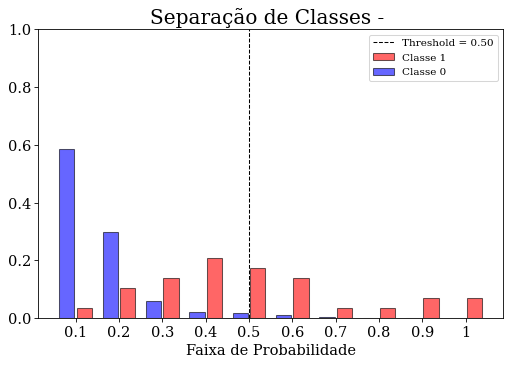

In [34]:
figura, classe0, classe1 = plot_separacao_classes(dataset=df_clf,
                                                colunas=['yprob'],
                                                titulos=[''],
                                                modelo=modelo,
                                                ponto_corte=0.5)

target
0    7910621
1         29
Name: count, dtype: int64


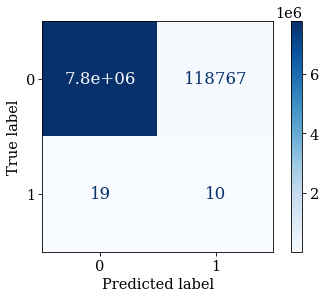

In [35]:
print(y_test.value_counts())
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

In [36]:
df.head()

,transaction_amount_total,test_transaction,sum_amount_same_doc_in_1H,sum_amount_same_doc_in_7D,sum_amount_same_doc_in_30D,count_amount_same_doc_in_1H,count_amount_same_doc_in_7D,count_amount_same_doc_in_30D,mean_amount_same_doc_in_1H,mean_amount_same_doc_in_7D,...,desvio_relativo_media_in_30D,last_status,transaction_id,fraud,transaction_datetime_request,hora,dia,dia_semana,rejected,target
0,0.9127,0.0010,0.9127,0.9127,0.9127,0.0010,0.0010,0.0010,1.2563,1.2563,...,1.0002,APPROVED,e270840982024073017160rtzfasefw1,0.0000,2024-05-01 03:00:28,3,1,2,0,0
1,4.7902,0.0010,4.7902,4.7902,4.7902,0.0010,0.0010,0.0010,3.3120,3.3120,...,1.0002,APPROVED,1ef348c43d3c666982c4d5e473ee2e8e,0.0000,2024-05-01 03:00:33,3,1,2,0,0
2,3.7975,0.0010,3.7975,3.7975,3.7975,0.0010,0.0010,0.0010,2.5841,2.5841,...,1.0002,APPROVED,1ef348c5a64269349a2c3ae445f7e334,0.0000,2024-05-01 03:00:56,3,1,2,0,0
3,4.6052,0.0010,4.6052,4.6052,4.6052,0.0010,0.0010,0.0010,3.1623,3.1623,...,1.0002,APPROVED,1ef348c8edb6612b99b3bf80cf6755e5,0.0000,2024-05-01 03:01:24,3,1,2,0,0
4,2.8798,0.0010,2.8798,2.8798,2.8798,0.0010,0.0010,0.0010,2.0543,2.0543,...,1.0002,APPROVED,1ef348cac45867aa99b31c920525183a,0.0000,2024-05-01 03:01:55,3,1,2,0,0


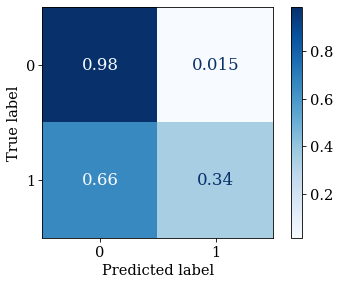

In [37]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true')
plt.show()

## Mudando o Threshold 

In [38]:
df_aux = pd.DataFrame()
df_aux['fraud'] = y_test
df_aux['y_pred'] = y_pred
df_aux['proba'] = yprob[:, 1]
df_aux['value'] = X_test.transaction_amount_total
df_aux['id'] = 1

def get_best_thresholds(probas, y_test, max_reject_fp, max_fraud_taken):
    fpr, tpr, th = roc_curve(y_test, probas)
    fnr = 1 - tpr
    max_reject_fp = max_reject_fp
    max_fraud_taken = max_fraud_taken

    reject = np.where(fpr > max_reject_fp)[0][0]
    review = np.where(fnr < max_fraud_taken)[0][0]
    print ("review_threshold", th[review], "reject_threshold", th[reject])
    return  th[review], th[reject]

def get_decision_results(review_threshold, reject_threshold, df):
    df.loc[df["proba"] < review_threshold, "action"] = "approve"
    df.loc[(df["proba"] >= review_threshold) & (df["proba"] < reject_threshold), "action"] = "review"
    df.loc[df["proba"] >= reject_threshold, "action"] = "reject"
    agg = df.groupby(["action", "fraud"]).agg({"id":"count", "value":"sum"}).reset_index().rename(columns={"id":"num_orders"}).set_index("action")
    
    agg_action = agg.groupby("action").agg({"num_orders":"sum", "value":"sum"})

    agg_action["fp"] = agg_action["num_orders"]/agg[agg["fraud"] == 1]["num_orders"]
    agg_action["#fraud"] = agg[agg["fraud"] == 1]["num_orders"]
    agg_action["$fraud"] = agg[agg["fraud"] == 1]["value"]
    agg_action["%fraud"] = (agg[agg["fraud"] == 1]["num_orders"]/agg_action['num_orders'])*100
    
    agg_action["%base"] = (agg_action['num_orders']/agg_action['num_orders'].sum())*100
    agg_action["%base_valor"] = (agg_action['value']/agg_action['value'].sum())*100
    
    agg_action["%fraud_total"] = (agg[agg["fraud"] == 1]["num_orders"]/agg[agg["fraud"] == 1]["num_orders"].sum())*100
    agg_action['$%fraud_total'] = (agg[agg["fraud"] == 1]["value"]/agg[agg["fraud"] == 1]["value"].sum())*100
    
    agg_action = round(agg_action,1)
    
    actions = ["approve", "review", "reject"]
    
    for action in actions:
        if action not in agg_action.index:
            agg_action.loc[action] = 0

    return agg_action.reindex(["reject", "review", "approve"])

natural = y_test.value_counts(normalize=True)[1]
max_reject_fp =  natural * 2
fraud_taken = 60/100

print(f'{natural:.6%}')
print(f'{max_reject_fp:.6%}')

review_threshold, reject_threshold  = get_best_thresholds(df_aux.proba, df_aux.fraud, max_reject_fp, fraud_taken)
get_decision_results(review_threshold=review_threshold, reject_threshold=reject_threshold, df=df_aux)

0.000367%
0.000733%
review_threshold 0.47 reject_threshold 0.96


,num_orders,value,fp,#fraud,$fraud,%fraud,%base,%base_valor,%fraud_total,$%fraud_total
action,,,,,,,,,,
reject,135,868.5000,NaN,NaN,NaN,NaN,0.0000,0.0000,NaN,NaN
review,159319,1297747.6000,13276.6000,12.0000,95.9000,0.0000,2.0000,4.9000,41.4000,54.2000
approve,7751196,25429232.4000,455952.7000,17.0000,81.0000,0.0000,98.0000,95.1000,58.6000,45.8000


### Mudando o Threshold para o ponto ótimo 

In [39]:
# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, yprob[:, 1])

# Encontrar o ponto de corte que maximiza a sensibilidade e especificidade (exemplo)
optimal_idx = np.argmax(tpr - fpr)
ponto_de_corte = thresholds[optimal_idx]

print(f'O ponto de corte ideal é: {ponto_de_corte}')

y_pred_alterado = (yprob[:, 1] > ponto_de_corte).astype(int)

O ponto de corte ideal é: 0.18


In [40]:
get_decision_results(review_threshold=ponto_de_corte, reject_threshold=ponto_de_corte*2, df=df_aux)

,num_orders,value,fp,#fraud,$fraud,%fraud,%base,%base_valor,%fraud_total,$%fraud_total
action,,,,,,,,,,
reject,340097,2501104.5000,17899.8000,19,145.5000,0.0000,4.3000,9.4000,65.5000,82.2000
review,809187,2604452.2000,101148.4000,8,33.0000,0.0000,10.2000,9.7000,27.6000,18.6000
approve,6761366,21622291.7000,3380683.0000,2,-1.5000,0.0000,85.5000,80.9000,6.9000,-0.9000


In [41]:
get_decision_results(review_threshold=0.6/2, reject_threshold=.6, df=df_aux)

,num_orders,value,fp,#fraud,$fraud,%fraud,%base,%base_valor,%fraud_total,$%fraud_total
action,,,,,,,,,,
reject,41250,349345.0000,5892.9000,7,57.6000,0.0000,0.5000,1.3000,24.1000,32.6000
review,424807,2795886.0000,30343.4000,14,102.4000,0.0000,5.4000,10.5000,48.3000,57.9000
approve,7444593,23582617.4000,930574.1000,8,16.9000,0.0000,94.1000,88.2000,27.6000,9.6000


In [42]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_alterado):.2%}')
print(f'Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_alterado):.2%}')
print(f'Jaccard: {jaccard_score(y_test, y_pred_alterado):.2%}')

Accuracy: 87.31%
Balanced accuracy: 88.48%
Jaccard: 0.00%


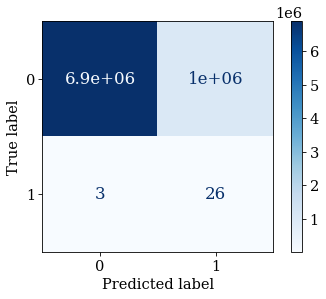

In [43]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_alterado, cmap='Blues')

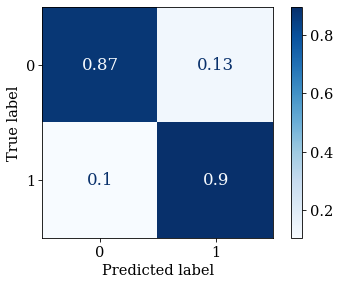

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_alterado, cmap='Blues', normalize='true')

plt.show()

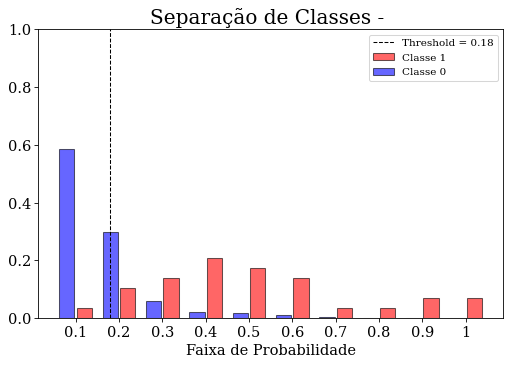

In [45]:
figura, classe0, classe1 = plot_separacao_classes(dataset=df_clf,
                                                colunas=['yprob'],
                                                titulos=[''],
                                                modelo=modelo,
                                                ponto_corte=ponto_de_corte)

In [46]:
pd.options.display.float_format = '{:.1f}'.format
pracc_metrics(y_test, yprob).T

,0,1,2,3,4,5,6,7,8,9
percentil,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
tp,28.0,25.0,21.0,15.0,10.0,7.0,5.0,4.0,2.0,0.0
tn,4628418.0,6986746.0,7467045.0,7643438.0,7781867.0,7869378.0,7900723.0,7907058.0,7909599.0,7910621.0
fp,3282203.0,923875.0,443576.0,267183.0,128754.0,41243.0,9898.0,3563.0,1022.0,0.0
fn,1.0,4.0,8.0,14.0,19.0,22.0,24.0,25.0,27.0,29.0
precision,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
recall,0.8,0.9,0.8,0.7,0.7,0.6,0.6,0.6,0.5,0.5
accuracy,0.6,0.9,0.9,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Mudando o Threshold para .38

In [47]:
ponto_de_corte_30 = 0.38

y_pred_alterado_30 = (yprob[:, 1] > ponto_de_corte_30).astype(int)

In [48]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_alterado_30):.2%}')
print(f'Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_alterado_30):.2%}')
print(f'Jaccard: {jaccard_score(y_test, y_pred_alterado_30):.2%}')

Accuracy: 96.40%
Balanced accuracy: 77.51%
Jaccard: 0.01%


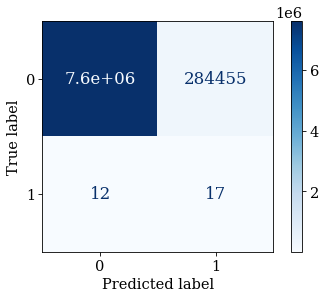

In [49]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_alterado_30, cmap='Blues')

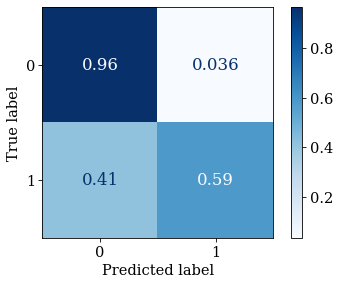

In [50]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_alterado_30, cmap='Blues', normalize='true')

plt.show()

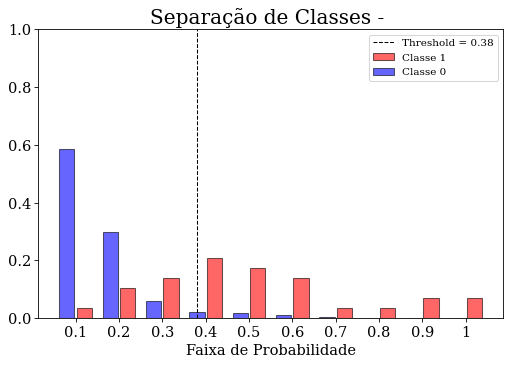

In [51]:
figura, classe0, classe1 = plot_separacao_classes(dataset=df_clf,
                                                colunas=['yprob'],
                                                titulos=[''],
                                                modelo=modelo,
                                                ponto_corte=ponto_de_corte_30)

In [52]:
pracc_metrics(y_test, yprob)

,percentil,tp,tn,fp,fn,precision,recall,accuracy
0,0.1,28,4628418,3282203,1,0.5,0.8,0.6
1,0.2,25,6986746,923875,4,0.5,0.9,0.9
2,0.3,21,7467045,443576,8,0.5,0.8,0.9
3,0.4,15,7643438,267183,14,0.5,0.7,1.0
4,0.5,10,7781867,128754,19,0.5,0.7,1.0
5,0.6,7,7869378,41243,22,0.5,0.6,1.0
6,0.7,5,7900723,9898,24,0.5,0.6,1.0
7,0.8,4,7907058,3563,25,0.5,0.6,1.0
8,0.9,2,7909599,1022,27,0.5,0.5,1.0
9,1.0,0,7910621,0,29,0.5,0.5,1.0


## Rescontruindo o DF

In [53]:
y_test.sum()

29

In [54]:
X_train_full['transaction_id']

0          e270840982024073017160rtzfasefw1
1          1ef348c43d3c666982c4d5e473ee2e8e
2          1ef348c5a64269349a2c3ae445f7e334
3          1ef348c8edb6612b99b3bf80cf6755e5
4          1ef348cac45867aa99b31c920525183a
                         ...               
2200093    1ef423d1fa94641dbd846b2730b6ec1c
2200094    1ef423d2222a6d37b6e7bbde4857863a
2200095    1ef423d25af86934b6e7b45133540ee1
2200096    1ef423d26c3862f0bd84d1098fa5f064
2200097    1ef423d2d7ba69a9b6e7e069dc450be7
Name: transaction_id, Length: 2200098, dtype: string

In [55]:
teste = pd.concat([X_test, transaction_id], axis='columns')
train = pd.concat([X_train, transaction_id_X_train])

In [56]:
X_test['y_real'] = y_test
X_test['fraud'] = fraud_X_test
X_test['transaction_id'] = transaction_id_X_test
X_test['transaction_datetime_request'] = transaction_datetime_request_X_test
X_test['predictions'] = y_pred
X_test['predictions_cutoff'] = y_pred_alterado
X_test['predictions_cutoff_70'] = y_pred_alterado_30
X_test['prob'] = yprob[:, 1]
X_test['last_status']= last_status_X_test

In [57]:
X_train['y_real'] = y_train
X_train['fraud'] = fraud_X_train
X_train['transaction_id'] = transaction_id_X_train
X_train['transaction_datetime_request'] = transaction_datetime_request_X_train
X_train['prob'] = yprob_train[:, 1]
X_train['predictions'] = 0
X_train['predictions_cutoff'] = 0
X_train['predictions_cutoff_70'] = 0
X_train['last_status']= last_status_X_train


In [58]:
X_test

,transaction_amount_total,sum_amount_same_doc_in_1H,sum_amount_same_doc_in_7D,sum_amount_same_doc_in_30D,count_amount_same_doc_in_1H,count_amount_same_doc_in_7D,count_amount_same_doc_in_30D,mean_amount_same_doc_in_1H,mean_amount_same_doc_in_7D,mean_amount_same_doc_in_30D,...,rejected,y_real,fraud,transaction_id,transaction_datetime_request,predictions,predictions_cutoff,predictions_cutoff_70,prob,last_status
2200098,3.0,10.8,15.2,16.7,5.9,10.3,11.8,3.4,3.4,3.4,...,0,0,0.0,1ef423d2eaf1672abd84107fb4bf2ad4,2024-07-15 00:00:00.692,0,0,0,0.1,APPROVED
2200099,5.0,5.0,5.0,5.3,0.0,0.0,0.7,3.5,3.5,3.2,...,0,0,0.0,1ef423d30f1169e8b6e7a13e87b70080,2024-07-15 00:00:04.600,0,0,0,0.0,APPROVED
2200100,5.7,10.8,15.2,16.7,5.9,10.3,11.8,3.4,3.4,3.4,...,0,0,0.0,1ef423d31b446c94b6e70079c39d5c92,2024-07-15 00:00:05.733,0,0,0,0.1,APPROVED
2200101,5.2,5.2,6.5,7.2,0.0,1.4,2.2,3.7,3.6,3.5,...,0,0,0.0,1ef423d32e736ae1b6e7b783f47cf352,2024-07-15 00:00:07.978,0,0,0,0.1,APPROVED
2200102,4.3,7.5,12.3,13.1,3.6,7.9,8.9,2.7,3.0,2.9,...,0,0,0.0,1ef423d359d06ae3bd84e34ea4176904,2024-07-15 00:00:12.000,0,1,1,0.4,APPROVED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10110743,3.9,3.9,3.9,3.9,0.0,0.0,0.0,2.7,2.7,2.7,...,0,0,0.0,e270840982024110622538qh9ozqxgyh,2024-11-06 22:53:18.516,0,0,0,0.0,APPROVED
10110744,-4.5,-4.5,-4.5,-4.5,0.0,0.0,0.0,0.3,0.3,0.3,...,0,0,0.0,e27084098202411062253q9sackdxm2o,2024-11-06 22:53:20.084,0,0,0,0.2,APPROVED
10110745,-4.5,-4.5,-4.5,-4.5,0.0,0.0,0.0,0.3,0.3,0.3,...,0,0,0.0,e27084098202411062253byfqpmittsb,2024-11-06 22:53:20.424,0,0,0,0.2,APPROVED
10110746,3.6,3.6,3.6,3.6,0.0,0.0,0.0,2.4,2.4,2.4,...,0,0,0.0,e27084098202411062253a26y2jxzjkl,2024-11-06 22:53:20.992,0,0,0,0.0,APPROVED


In [59]:
X_test['prob'].describe(percentiles=[.75, .80, .85, .90, .95, .99])

count   7910650.0
mean          0.1
std           0.1
min           0.0
50%           0.1
75%           0.2
80%           0.2
85%           0.2
90%           0.2
95%           0.3
99%           0.6
max           1.0
Name: prob, dtype: float64

In [60]:
X_test

,transaction_amount_total,sum_amount_same_doc_in_1H,sum_amount_same_doc_in_7D,sum_amount_same_doc_in_30D,count_amount_same_doc_in_1H,count_amount_same_doc_in_7D,count_amount_same_doc_in_30D,mean_amount_same_doc_in_1H,mean_amount_same_doc_in_7D,mean_amount_same_doc_in_30D,...,rejected,y_real,fraud,transaction_id,transaction_datetime_request,predictions,predictions_cutoff,predictions_cutoff_70,prob,last_status
2200098,3.0,10.8,15.2,16.7,5.9,10.3,11.8,3.4,3.4,3.4,...,0,0,0.0,1ef423d2eaf1672abd84107fb4bf2ad4,2024-07-15 00:00:00.692,0,0,0,0.1,APPROVED
2200099,5.0,5.0,5.0,5.3,0.0,0.0,0.7,3.5,3.5,3.2,...,0,0,0.0,1ef423d30f1169e8b6e7a13e87b70080,2024-07-15 00:00:04.600,0,0,0,0.0,APPROVED
2200100,5.7,10.8,15.2,16.7,5.9,10.3,11.8,3.4,3.4,3.4,...,0,0,0.0,1ef423d31b446c94b6e70079c39d5c92,2024-07-15 00:00:05.733,0,0,0,0.1,APPROVED
2200101,5.2,5.2,6.5,7.2,0.0,1.4,2.2,3.7,3.6,3.5,...,0,0,0.0,1ef423d32e736ae1b6e7b783f47cf352,2024-07-15 00:00:07.978,0,0,0,0.1,APPROVED
2200102,4.3,7.5,12.3,13.1,3.6,7.9,8.9,2.7,3.0,2.9,...,0,0,0.0,1ef423d359d06ae3bd84e34ea4176904,2024-07-15 00:00:12.000,0,1,1,0.4,APPROVED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10110743,3.9,3.9,3.9,3.9,0.0,0.0,0.0,2.7,2.7,2.7,...,0,0,0.0,e270840982024110622538qh9ozqxgyh,2024-11-06 22:53:18.516,0,0,0,0.0,APPROVED
10110744,-4.5,-4.5,-4.5,-4.5,0.0,0.0,0.0,0.3,0.3,0.3,...,0,0,0.0,e27084098202411062253q9sackdxm2o,2024-11-06 22:53:20.084,0,0,0,0.2,APPROVED
10110745,-4.5,-4.5,-4.5,-4.5,0.0,0.0,0.0,0.3,0.3,0.3,...,0,0,0.0,e27084098202411062253byfqpmittsb,2024-11-06 22:53:20.424,0,0,0,0.2,APPROVED
10110746,3.6,3.6,3.6,3.6,0.0,0.0,0.0,2.4,2.4,2.4,...,0,0,0.0,e27084098202411062253a26y2jxzjkl,2024-11-06 22:53:20.992,0,0,0,0.0,APPROVED


In [61]:
X_test['fraud'] = y_test
X_test['fraud'].sum()

29

In [62]:
X_test[(X_test['y_real']==1) & (X_test['prob']<= ponto_de_corte)]

,transaction_amount_total,sum_amount_same_doc_in_1H,sum_amount_same_doc_in_7D,sum_amount_same_doc_in_30D,count_amount_same_doc_in_1H,count_amount_same_doc_in_7D,count_amount_same_doc_in_30D,mean_amount_same_doc_in_1H,mean_amount_same_doc_in_7D,mean_amount_same_doc_in_30D,...,rejected,y_real,fraud,transaction_id,transaction_datetime_request,predictions,predictions_cutoff,predictions_cutoff_70,prob,last_status
4044901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0,1,1,e27084098202408110510t9vbteuzbk5,2024-08-11 05:10:19.822,0,0,0,0.2,FRAUD
6515896,-4.5,-4.5,-4.5,-4.5,0.0,0.0,0.0,0.3,0.3,0.3,...,0,1,1,e27084098202409181203ktruvewchw1,2024-09-18 12:03:38.537,0,0,0,0.2,CONT_FRAUD
9213261,3.0,3.0,3.0,3.0,0.0,0.0,0.0,2.1,2.1,2.1,...,0,1,1,e27084098202410240710l3itromvxwb,2024-10-24 07:10:24.145,0,0,0,0.0,CONT_FRAUD


In [63]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7910650 entries, 2200098 to 10110747
Data columns (total 40 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   transaction_amount_total             float64       
 1   sum_amount_same_doc_in_1H            float64       
 2   sum_amount_same_doc_in_7D            float64       
 3   sum_amount_same_doc_in_30D           float64       
 4   count_amount_same_doc_in_1H          float64       
 5   count_amount_same_doc_in_7D          float64       
 6   count_amount_same_doc_in_30D         float64       
 7   mean_amount_same_doc_in_1H           float64       
 8   mean_amount_same_doc_in_7D           float64       
 9   mean_amount_same_doc_in_30D          float64       
 10  std_amount_in_1H                     float64       
 11  std_amount_in_7D                     float64       
 12  std_amount_in_30D                    float64       
 13  amount_7D_1H             

In [64]:
feature_names

Index(['transaction_amount_total', 'sum_amount_same_doc_in_1H',
       'count_amount_same_doc_in_1H', 'mean_amount_same_doc_in_30D',
       'std_amount_in_1H', 'std_amount_in_7D', 'std_amount_in_30D',
       'amount_30d_7d', 'behav_increase_7d_1H_amount',
       'behav_increase_30d_7d_amount', 'recebedores_unicos_por_pagador',
       'pagadores_unicos_por_recebedor', 'razao_valor_frequencia_1H',
       'razao_valor_frequencia_7D', 'roc_razao_valor_frequencia_1H',
       'roc_razao_valor_frequencia_7D', 'roc_razao_valor_frequencia_30D',
       'flag_first_time_receiver', 'desvio_relativo_media_in_30D', 'rejected'],
      dtype='object')

In [65]:
X_test.columns.isin(X_train.columns)

array([ True,  True, False, False,  True, False, False, False, False,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [66]:
df_probs_full = pd.concat([X_test, X_train], ignore_index=True)


In [67]:
df_probs_full.to_parquet('dados/df_cashout_probs.parquet')

X_train.to_parquet('dados/df_cashout_train_preds.parquet')
X_test.to_parquet('dados/df_cashout_teste_preds.parquet')

## Graficos e Valores apresentação

### DFs

In [68]:
# df_probs_full = pd.read_parquet('dados/df_cashout_probs.parquet')
df_probs_full = X_test.copy()

In [69]:
file_path_og = 'dados/df_cashout_treino_feature_eng.parquet'
df_og = pd.read_parquet(file_path_og)

In [70]:
df_og_valores = pd.merge(df_og.drop('fraud', axis='columns'), df_probs_full[['fraud', 'prob']], left_index=True, right_index=True, how='left')

In [71]:
df_og_valores = df_og_valores.dropna(axis='rows')
df_og_valores

,transaction_id,transaction_amount_total,transaction_datetime_request,last_status,transaction_payer_registration_data_doc,transaction_receiver_registration_data_doc,hora,dia,dia_semana,test_transaction,...,roc_razao_valor_frequencia_7D,roc_razao_valor_frequencia_30D,data_transacao_in,payer_receiver,flag_first_time_receiver,desvio_relativo_media_in_1H,desvio_relativo_media_in_7D,desvio_relativo_media_in_30D,fraud,prob
2200098,1ef423d2eaf1672abd84107fb4bf2ad4,20.0,2024-07-15 00:00:00.692,APPROVED,34935286000119,0,0,15,0,0,...,0.0,-0.0,2024-07-15,349352860001190,0,0.1,0.1,0.1,0.0,0.1
2200099,1ef423d30f1169e8b6e7a13e87b70080,150.0,2024-07-15 00:00:04.600,APPROVED,31703183000135,10586952667,0,15,0,0,...,0.0,-0.0,2024-07-15,3170318300013510586952667,0,1.0,1.0,1.5,0.0,0.0
2200100,1ef423d31b446c94b6e70079c39d5c92,287.0,2024-07-15 00:00:05.733,APPROVED,34935286000119,0,0,15,0,0,...,0.0,0.0,2024-07-15,349352860001190,0,2.1,2.0,2.1,0.0,0.1
2200101,1ef423d32e736ae1b6e7b783f47cf352,180.4,2024-07-15 00:00:07.978,APPROVED,47864922000100,07122451380,0,15,0,0,...,-0.0,0.0,2024-07-15,4786492200010007122451380,0,1.0,1.1,1.2,0.0,0.1
2200102,1ef423d359d06ae3bd84e34ea4176904,75.0,2024-07-15 00:00:12.000,APPROVED,51116787000192,51116787000192,0,15,0,0,...,0.0,-0.0,2024-07-15,5111678700019251116787000192,0,1.5,0.9,1.0,0.0,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10110743,e270840982024110622538qh9ozqxgyh,50.0,2024-11-06 22:53:18.516,APPROVED,31703183000135,03213828548,22,6,2,0,...,-0.0,0.0,2024-11-06,3170318300013503213828548,1,1.0,1.0,1.0,0.0,0.0
10110744,e27084098202411062253q9sackdxm2o,0.0,2024-11-06 22:53:20.084,APPROVED,51824919000130,49888792830,22,6,2,1,...,-0.0,-0.0,2024-11-06,5182491900013049888792830,1,1.0,1.0,1.0,0.0,0.2
10110745,e27084098202411062253byfqpmittsb,0.0,2024-11-06 22:53:20.424,APPROVED,05563165000195,11804470694,22,6,2,1,...,0.0,0.0,2024-11-06,0556316500019511804470694,1,1.0,1.0,1.0,0.0,0.2
10110746,e27084098202411062253a26y2jxzjkl,36.0,2024-11-06 22:53:20.992,APPROVED,38333425000195,72295546400,22,6,2,0,...,-0.0,-0.0,2024-11-06,3833342500019572295546400,1,1.0,1.0,1.0,0.0,0.0


### Valores 

In [72]:
corte = 0.38

df_probs_full_le_corte = df_og_valores[df_og_valores['prob'] < corte]
df_probs_full_gt_corte = df_og_valores[df_og_valores['prob'] >= corte]

sum_total_fraud = df_og_valores[df_og_valores['fraud'] == 1]['transaction_amount_total'].sum()
count_total_fraud = df_og_valores[df_og_valores['fraud'] == 1]['transaction_amount_total'].count()

sum_frauds_lower = df_probs_full_le_corte[df_probs_full_le_corte['fraud'] == 1]['transaction_amount_total'].sum()
sum_frauds_greater = df_probs_full_gt_corte[df_probs_full_gt_corte['fraud'] == 1]['transaction_amount_total'].sum()

count_frauds_lower = df_probs_full_le_corte[df_probs_full_le_corte['fraud'] == 1]['transaction_amount_total'].count()
count_frauds_greater = df_probs_full_gt_corte[df_probs_full_gt_corte['fraud'] == 1]['transaction_amount_total'].count()


print(f'''{df_probs_full_le_corte.shape[0]/df_og_valores.shape[0]:.2%}
{df_probs_full_gt_corte.shape[0]/df_og_valores.shape[0]:.2%}''')

96.17%
3.83%


In [73]:
df_probs_full_le_corte.shape, df_probs_full_gt_corte.shape

((7607963, 43), (302687, 43))

In [74]:
print(f'% da Qtde de fraude Abaixo do corte: {count_frauds_lower / count_total_fraud:.2%}')
print(f'% da Sum de fraude Abaixo do corte: {(sum_frauds_lower) / sum_total_fraud:.2%}')

% da Qtde de fraude Abaixo do corte: 34.48%
% da Sum de fraude Abaixo do corte: 9.74%


In [75]:
print(f'% da Qtde de fraude Acima do corte: {count_frauds_greater / count_total_fraud:.2%}')
print(f'% da Sum de fraude Acima do corte: {(sum_frauds_greater) / sum_total_fraud:.2%}')

% da Qtde de fraude Acima do corte: 65.52%
% da Sum de fraude Acima do corte: 90.26%


### Boxplot

In [76]:
df_og_valores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7910650 entries, 2200098 to 10110747
Data columns (total 43 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   transaction_id                              string        
 1   transaction_amount_total                    float64       
 2   transaction_datetime_request                datetime64[ns]
 3   last_status                                 string        
 4   transaction_payer_registration_data_doc     string        
 5   transaction_receiver_registration_data_doc  string        
 6   hora                                        int32         
 7   dia                                         int32         
 8   dia_semana                                  int32         
 9   test_transaction                            int32         
 10  sum_amount_same_doc_in_1H                   float64       
 11  sum_amount_same_doc_in_7D                   floa

In [77]:
features = [
# 'transaction_amount_total',
# 'std_amount_in_1H',
# 'std_amount_in_7D',
# 'std_amount_in_30D',
# 'mean_amount_same_doc_in_30D',
# 'mean_amount_same_doc_in_1H',
# 'mean_amount_same_doc_in_7D',
'amount_7D_1H',
'amount_30d_7d',
# 'behav_increase_7d_1H_amount',
'behav_increase_30d_7d_amount',
# 'sum_amount_same_doc_in_1H',
# 'sum_amount_same_doc_in_7D',
# 'sum_amount_same_doc_in_30D',
# 'count_amount_same_doc_in_1H',
# 'count_amount_same_doc_in_7D',
# 'count_amount_same_doc_in_30D',
# 'transacoes_unicas_pagador_recebedor',
# 'recebedores_unicos_por_pagador',
# 'pagadores_unicos_por_recebedor',
# 'flag_first_time_receiver',
# 'desvio_relativo_media_in_1H',
# 'desvio_relativo_media_in_7D',
# 'desvio_relativo_media_in_30D',
# 'razao_valor_frequencia_1H',
# 'razao_valor_frequencia_7D',
# 'razao_valor_frequencia_30D',
'roc_razao_valor_frequencia_1H',
'roc_razao_valor_frequencia_7D',
'roc_razao_valor_frequencia_30D',
'fraud']

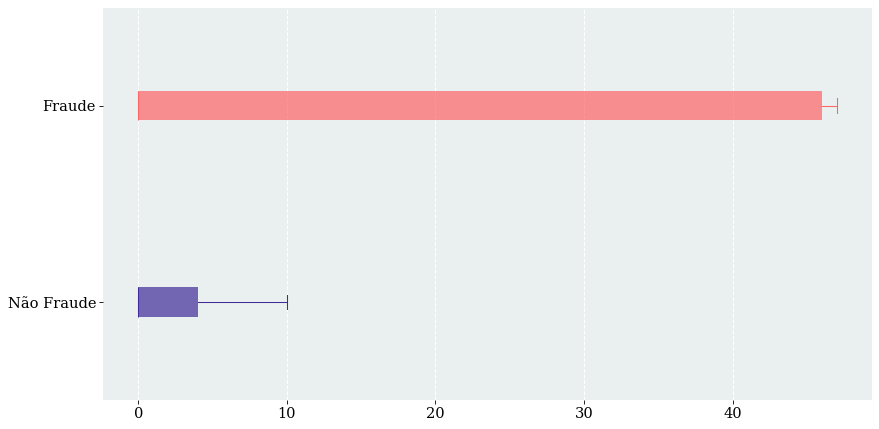

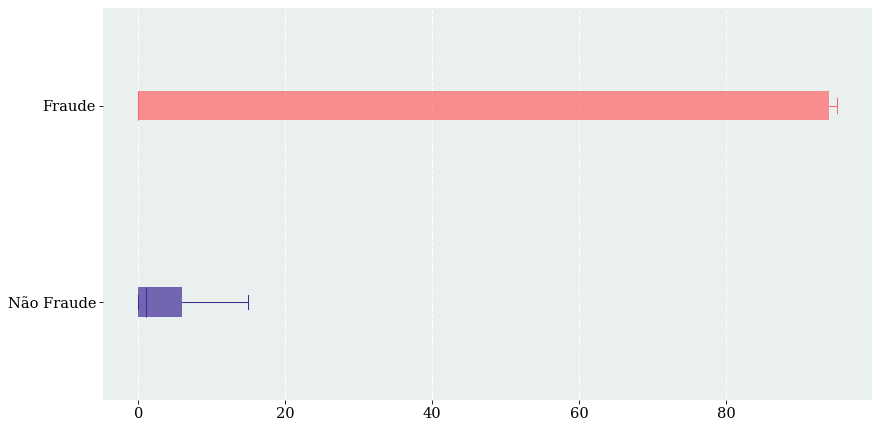

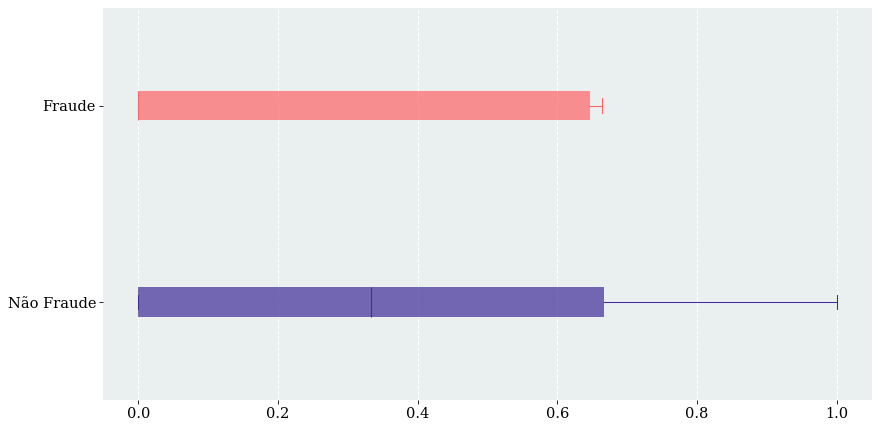

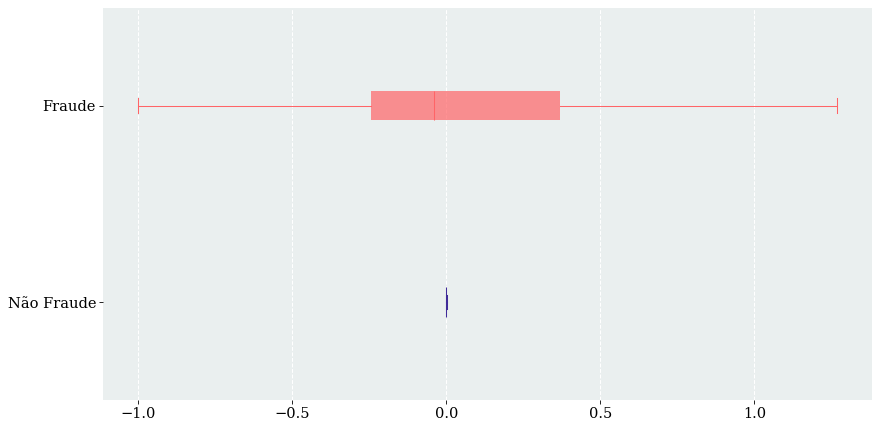

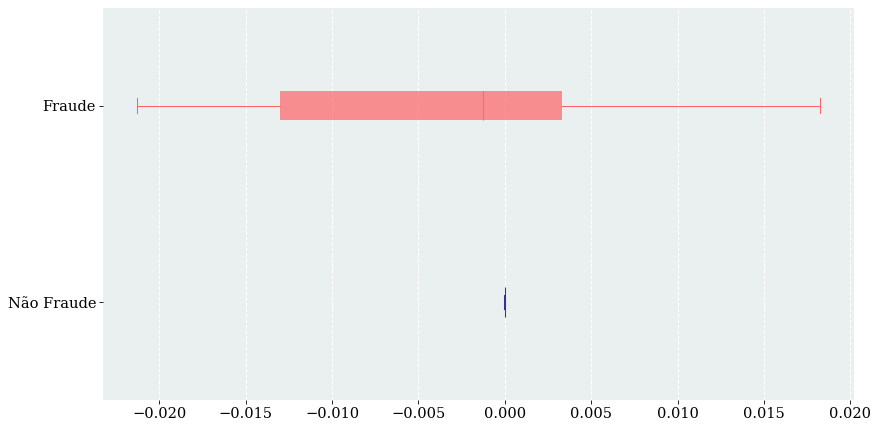

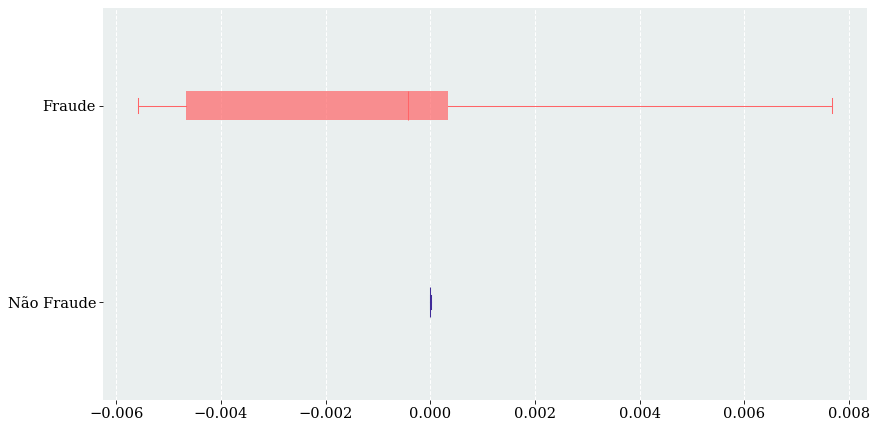

In [78]:
df_bp = df_og_valores[features]
import gc

color_class_0 = '#402b99'  
color_class_1 = '#FF6467'  

# Supondo que seu DataFrame se chama 'df_bp' e a coluna fraud seja 'fraud'
for i in range(0, df_bp.shape[1] - 1): 
    coluna = df_bp.columns[i]
    plt.figure(figsize=(12, 6))

    class_0_data = df_bp[df_bp['fraud'] == 0].iloc[:, i]  
    class_1_data = df_bp[df_bp['fraud'] == 1].iloc[:, i]  

    combined_data = [class_0_data, class_1_data]


    bp = plt.boxplot(combined_data, vert=False,
                    patch_artist=True, showfliers=False,
                    boxprops=dict(alpha=0.7)
                    )
    
    # for i, box in enumerate(bp['boxes']):
    #     if i == 0:  # Caixa para a classe 0
    #         box.set_facecolor(color_class_0)
    #         # Set whiskers color for class 0
    #         for whisker in bp['whiskers'][i*2:i*2+2]:
    #             whisker.set_color(color_class_0)
    #     else:  # Caixa para a classe 1
    #         box.set_facecolor(color_class_1)
    #         # Set whiskers color for class 1
    #         for whisker in bp['whiskers'][i*2:i*2+2]:
    #             whisker.set_color(color_class_1)
    
    for i, box in enumerate(bp['boxes']):
        if i == 0:  # Caixa para a classe 0
            box.set_facecolor(color_class_0)
            box.set_edgecolor('none')  # Remove the border by setting edgecolor to 'none'

            # Color whiskers for class 0
            for whisker in bp['whiskers'][i*2:i*2+2]:
                whisker.set_color(color_class_0)

            # Color the caps for class 0
            for cap in bp['caps'][i*2:i*2+2]:
                cap.set_color(color_class_0)

            # Color the median for class 0
            median = bp['medians'][i]
            median.set_color(color_class_0)

        else:  # Caixa para a classe 1
            box.set_facecolor(color_class_1)
            box.set_edgecolor('none')  # Remove the border by setting edgecolor to 'none'

            # Color whiskers for class 1
            for whisker in bp['whiskers'][i*2:i*2+2]:
                whisker.set_color(color_class_1)

            # Color the caps for class 1
            for cap in bp['caps'][i*2:i*2+2]:
                cap.set_color(color_class_1)

            # Color the median for class 1
            median = bp['medians'][i]
            median.set_color(color_class_1)
            
        
    ax = plt.gca()  # Get current axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_facecolor('#eaefef')
    
    # Personalize os rótulos e título do gráfico
    # plt.title(f'{coluna}: Não Fraude vs Fraude')
    plt.yticks([1, 2], ['Não Fraude', 'Fraude'])  # Label para os dois grupos

    plt.grid(True, which='both', axis='x', color='white', linestyle='--', linewidth=1)


    # plt.xlabel('Value')
    plt.tight_layout()
    plt.show()
    gc.collect()


In [79]:
# df_og = pd.read_parquet('dados/df_cashout_teste_preds.parquet')

In [80]:
# df_og_test = df_og.index.isin(X_test.index)

In [81]:
# X_test['transaction_id'] = transaction_id_X_test
# X_test['predictions'] = y_pred
# X_test['predictions_cutoff'] = y_pred_alterado
# X_test['prob'] = yprob[:, 1]

In [82]:
# break

In [83]:
from time import *

toc = time()

def convert_seconds(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

time_format = convert_seconds(toc-tic)

print(f'Tempo de Processamento: {time_format}')

Tempo de Processamento: 00:04:15
